# ESDA

Exploratory Spatial Data Analysis using PySal

Useful links: 

- http://pysal.org/notebooks/viz/splot/esda_morans_viz.html

- https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee

- http://ljwolf.org/post/spatial_acf/

- Original LISA article: https://dces.webhosting.cals.wisc.edu/wp-content/uploads/sites/128/2013/08/W4_Anselin1995.pdf

Import libraries

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local,Moran_BV,Moran_Local_BV
from splot.esda import moran_scatterplot,plot_local_autocorrelation,lisa_cluster,plot_moran_bv
import geopandas as gpd
%matplotlib inline

Loading shp file for cities in Brazil

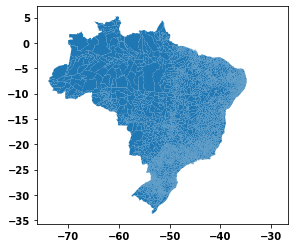

In [2]:
gdf = gpd.read_file('municipios/BRMUE250GC_SIR.shp')
gdf.plot()

## Spatial autocorrelation
Spatial autocorrelation describes the presence or absence of spacial variations in a given variable.

- Positive spatial autocorrelation: areas close to each other have similar values (High-high or Low-low)
- Negative spatial autocorrelation: neighbourhood areas are different from each other (Low-high or High-low) 

There are two types of spatial autocorrelation:

- Global: focuses on the overall trend in the dataset and gives us information about the degree of clustering 
- Local: detects variability and divergence in the dataset

Calculating contiguity weights (spacial similarity) with Queen.from_dataframe

"Spatial similarity relation refers to similarity among and between objects on maps or in geographic space"
(source: https://www.sciencedirect.com/science/article/pii/S1674984715000191)

Spatial weights are how we determine the area’s neighborhood

In [3]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

('WARNING: ', 1773, ' is an island (no neighbors)')
('WARNING: ', 2170, ' is an island (no neighbors)')


C:\Users\marco\Anaconda3\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1773, 2170.
  warnings.warn(message)


Taking a look at gdf 

In [4]:
gdf

,NM_MUNICIP,CD_GEOCMU,geometry
0,ABADIA DE GOIÃS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7..."
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1..."
2,ABADIÃNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0..."
3,ABAETÃ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8..."
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571..."
...,...,...,...
5567,XIQUE-XIQUE,2933604,"POLYGON ((-42.38095 -10.24423, -42.37974 -10.2..."
5568,ZABELÃ,2517407,"POLYGON ((-37.14957 -8.02374, -37.14928 -8.024..."
5569,ZACARIAS,3557154,"POLYGON ((-49.99275 -21.03884, -49.99214 -21.0..."
5570,ZÃ DOCA,2114007,"POLYGON ((-45.92061 -3.02780, -45.91877 -3.028..."


CD_GEOCMU is the 7-digit city code, we need to convert it to the standard 6-digit code

In [5]:
cadmun = pd.read_csv('../util/CADMUN.csv')
cadmun = cadmun[["MUNCOD", "MUNCODDV"]]
gdf["CD_GEOCMU"] = gdf["CD_GEOCMU"].astype(int)
gdf_city = pd.merge(gdf, cadmun,  left_on="CD_GEOCMU", right_on="MUNCODDV", how="left")

In [6]:
gdf_city.head()

,NM_MUNICIP,CD_GEOCMU,geometry,MUNCOD,MUNCODDV
0,ABADIA DE GOIÃS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7...",520005.0,5200050.0
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1...",310010.0,3100104.0
2,ABADIÃNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0...",520010.0,5200100.0
3,ABAETÃ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8...",310020.0,3100203.0
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571...",150010.0,1500107.0


Merging with suicide CSV to get SUICIDE_RATE for each city

In [7]:
suicide = pd.read_csv('../CSV/Suicide/suicide_rates_08_18.csv', sep=',', index_col=0)
suicide['AVG_SUICIDE_RATE'] = np.mean(suicide.filter(regex=("RATE_*")), axis=1)
suicide.head()

,MUNCOD,RATE_08,RATE_09,RATE_10,RATE_11,RATE_12,RATE_13,RATE_14,RATE_15,RATE_16,RATE_17,RATE_18,AVG_SUICIDE_RATE
0,110001,20.344224,8.212203,8.189337,4.127456,12.464166,7.773632,3.898332,11.728829,7.841292,11.793844,4.316485,9.153618
1,110002,9.458389,2.338060,4.427031,4.368243,9.703818,1.974938,4.860976,4.789226,5.665936,9.315758,1.883807,5.344198
2,110003,0.000000,14.936520,0.000000,0.000000,0.000000,15.396459,0.000000,31.471282,15.900779,0.000000,18.389114,8.735832
3,110004,5.110972,7.626311,2.544497,1.266480,5.042229,1.164646,5.776607,6.878683,10.241588,5.649271,9.432516,5.521254
4,110005,0.000000,0.000000,11.743981,0.000000,11.868028,0.000000,0.000000,11.119760,11.136478,5.576001,6.081245,5.229590


In [8]:
suicide = suicide[['MUNCOD', 'AVG_SUICIDE_RATE']]
result = pd.merge(gdf_city, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE"]]
result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0) #filling null values with 0

Defining the y dimension

In [9]:
y = result['AVG_SUICIDE_RATE'].values
y.shape

(5572,)

### Global spatial autocorrelation

Calculating Moran's I (measure of global spatial autocorrelation)

In [10]:
from esda.moran import Moran

moran = Moran(y, w)
moran.I

0.4612716123019056

We conclude that there is a positive spatial autocorrelation in this dataset.

Visualizing the global spatial autocorrelation

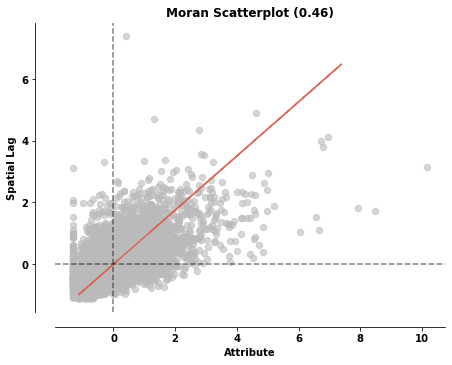

In [11]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Local spatial autocorrelation

Calculating Moran Local

In [12]:
moran_loc = Moran_Local(y, w)

C:\Users\marco\Anaconda3\lib\site-packages\esda\moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


Plotting Moran's Local Scatter Plot

The scatter plot divides the areas into the four groups:
- High-high: top right
- High-low: bottom right
- Low-low: bottom left
- Low-high: top left


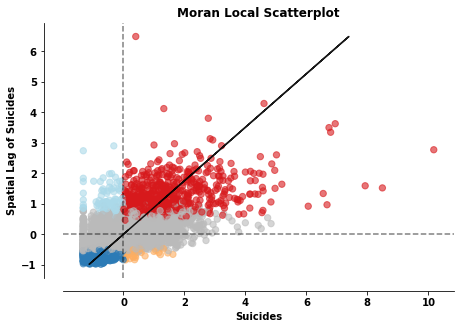

In [13]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial Lag of Suicides')
plt.show()

Visualizing the clusters on a map

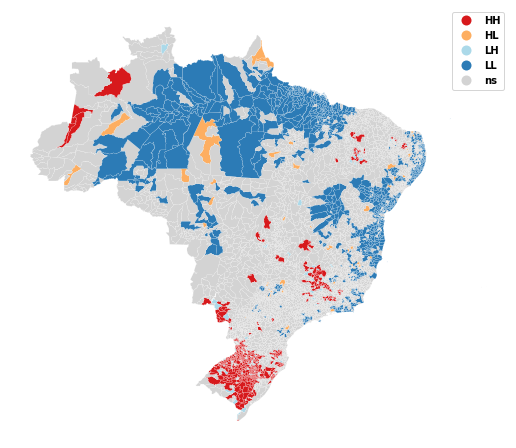

In [14]:
lisa_cluster(moran_loc, result, p=0.05, figsize = (9,9))
plt.show()

Combined visualizations 

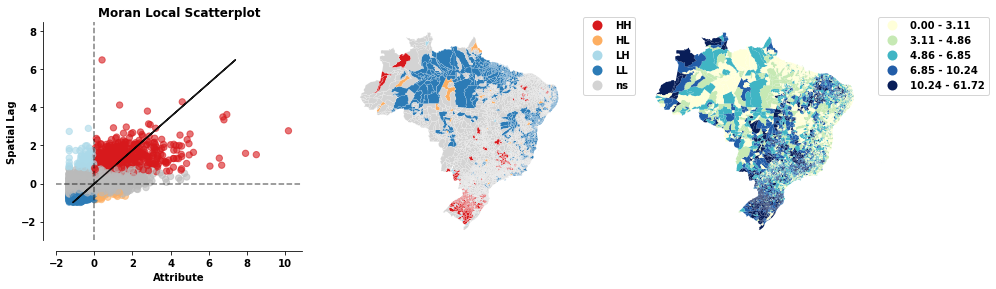

In [15]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, result, 'AVG_SUICIDE_RATE')
plt.show()

Choropleth map of suicide rates in Brazil (2017)

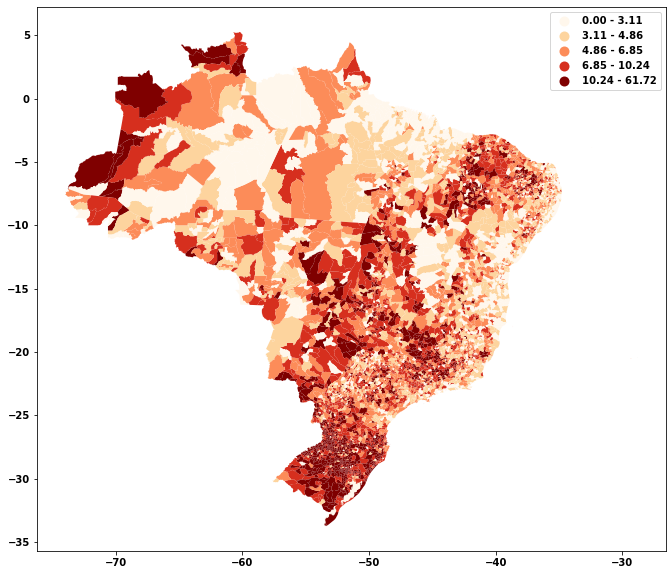

In [16]:
fig = result.plot(column='AVG_SUICIDE_RATE', legend=True, figsize=(15, 10),cmap='OrRd', scheme='quantiles')
plt.show()

In [ ]:
import geoplot as gplt
gplt.choropleth(result, hue='AVG_SUICIDE_RATE', cmap='OrRd',linewidth=0.2, scheme='quantiles',
                legend=True)

## Bivariate Moran Statistics

Inspecting the relationship of two variables and their position in space 

Loading disease data and merging with gdf

In [ ]:
cancer = pd.read_csv('../CSV/TabNet/Rates/CANCER_RATE_08_18.csv', sep=',', index_col=0)
cancer['AVG_CANCER_RATE'] = np.mean(cancer.filter(regex=("RATE_*")), axis=1)

In [ ]:
cancer = cancer[['MUNCOD', 'AVG_CANCER_RATE']]
result = pd.merge(gdf_city, cancer, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = pd.merge(result, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE", 'AVG_CANCER_RATE']]
result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0)
result['AVG_CANCER_RATE'] = result['AVG_CANCER_RATE'].fillna(0)

In [ ]:
result.head()

Bivariate Moran Statistics describe the correlation between one variable and the spatial lag of another variable
 
IMPORTANT: Bivariate Moran Statistics do not take the inherent correlation between the two variables at the same location into account.

In [ ]:
x = result['AVG_SUICIDE_RATE'].values
y = result['AVG_CANCER_RATE'].values

Calculating Moran's BV I

A single statistic (and accompanying (p)-values computed using permutation methods) that relates the values of attribute (x) to the lag of (y).

In [ ]:
moran_bv = Moran_BV(y, x, w)
moran_bv.I

Plotting Moran BV

In [ ]:
plot_moran_bv(moran_bv)
plt.show()

Calculating BV Moran Local

In [ ]:
moran_loc_bv = Moran_Local_BV(y, x, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial lag of cancer')
plt.show()

In [ ]:
plot_local_autocorrelation(moran_loc_bv, result, 'AVG_CANCER_RATE')
plt.show()

## Table of Moran BV I (Suicide vs. Disease)

Let's see the Moran BV I value for each disease:

In [ ]:
import glob
import re

In [ ]:
root = "../"
path = root + "CSV/TabNet/Rates/"
all_files = glob.glob(path + "*.csv")

In [ ]:
all_files

In [ ]:
morans = []
diseases = []
for file in all_files:
    # disease name
    disease = file
    disease = disease.split('\\')[1].split('_RATE')[0]
    # read file
    rates = pd.read_csv(file.replace('\\', '/'), sep=',', index_col=0)
    # calculate average
    rates['AVG_DISEASE_RATE'] = np.mean(rates.filter(regex=("RATE_*")), axis=1)
    # merges with suicide and gdf
    rates = rates[['MUNCOD', 'AVG_DISEASE_RATE']]
    result = pd.merge(gdf_city, rates, left_on="MUNCOD", right_on="MUNCOD", how="left")
    result = pd.merge(result, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
    result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE", 'AVG_DISEASE_RATE']]
    # fill NaN's with 0
    result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0)
    result['AVG_DISEASE_RATE'] = result['AVG_DISEASE_RATE'].fillna(0)

    x = result['AVG_SUICIDE_RATE'].values
    y = result['AVG_DISEASE_RATE'].values

    moran_bv = Moran_BV(y, x, w)
    
    diseases.append(disease)
    morans.append(moran_bv.I)

In [ ]:
morans_data = {'Doenças': diseases, 'Moran BV I': morans}
morans_data = pd.DataFrame(data=morans_data)
morans_data.sort_values(by=['Moran BV I'], ascending=False)